In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.00'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models,Model,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path='/kaggle/input/radiography-dataset-covid/COVID-19_Radiography_Dataset/Train'
test_path='/kaggle/input/radiography-dataset-covid/COVID-19_Radiography_Dataset/Test'

2025-11-09 17:16:26.538162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762708586.561715     477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762708586.568693     477 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [4]:
val_test_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [5]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 13546 images belonging to 4 classes.


In [6]:
val_data=val_test_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 3384 images belonging to 4 classes.


In [7]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4235 images belonging to 4 classes.


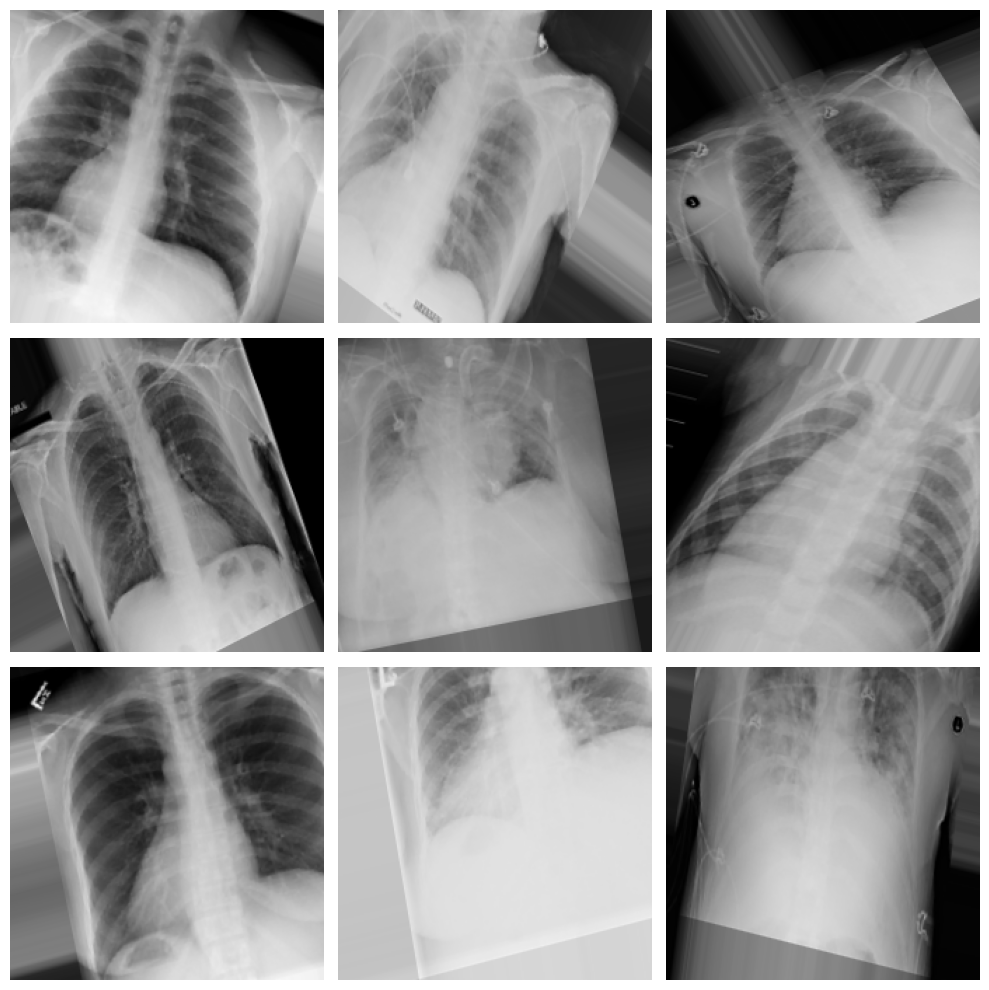

In [8]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [10]:
print(class_weights_dict)

{0: 1.4634831460674158, 1: 0.8800675675675675, 2: 0.5191629618273801, 3: 3.9332171893147505}


In [11]:
from tensorflow.keras.applications import Xception
base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1762708624.968660     477 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1762708624.968999     477 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
base_model.trainable=False

In [13]:
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.25),
    layers.Dense(units=256,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(units=128,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.15),
    layers.Dense(units=64,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=4,activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,665,132 (90.28 MB)

 Trainable params: 2,799,684 (10.68 MB)

 Non-trainable params: 20,865,448 (79.60 MB)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC,TopKCategoricalAccuracy
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=3,name='top3'),AUC(name='auc')])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)

In [16]:
history1=model.fit(train_data,validation_data=val_data,epochs=30,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1762708658.304498     550 service.cc:148] XLA service 0x7c449c013580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762708658.304559     550 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762708659.668646     550 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/424 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.2969 - auc: 0.5487 - loss: 1.9884 - top3: 0.8047   

I0000 00:00:1762708667.728971     550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 ━━━━━━━━━━━━━━━━━━━━ 212s 459ms/step - accuracy: 0.4682 - auc: 0.7143 - loss: 1.2163 - top3: 0.8659 - val_accuracy: 0.6797 - val_auc: 0.8867 - val_loss: 0.8210 - val_top3: 0.9675
Epoch 2/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 178s 419ms/step - accuracy: 0.6378 - auc: 0.8500 - loss: 0.8186 - top3: 0.9390 - val_accuracy: 0.7110 - val_auc: 0.9023 - val_loss: 0.7506 - val_top3: 0.9858
Epoch 3/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 178s 420ms/step - accuracy: 0.6751 - auc: 0.8810 - loss: 0.7066 - top3: 0.9612 - val_accuracy: 0.7996 - val_auc: 0.9481 - val_loss: 0.5534 - val_top3: 0.9905
Epoch 4/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 174s 410ms/step - accuracy: 0.7022 - auc: 0.8934 - loss: 0.6704 - top3: 0.9664 - val_accuracy: 0.7329 - val_auc: 0.9196 - val_loss: 0.6762 - val_top3: 0.9917
Epoch 5/30
424/424 ━━━━━━━━━━━━━━━━━━━━ 175s 413ms/step - accuracy: 0.7220 - auc: 0.9059 - loss: 0.6228 - top3: 0.9775 - val_accuracy: 0.7893 - val_auc: 0.9471 - val_loss: 0.5514 - val_top3: 0.9926
Epoch 6/30
424/424 ━━

In [17]:
base_model.trainable=True

In [18]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy',TopKCategoricalAccuracy(k=3,name='top3'),AUC(name='auc')])

In [19]:
history2=model.fit(train_data,validation_data=val_data,epochs=15,batch_size=32,callbacks=[early_stopper],verbose=1,class_weight=class_weights_dict)

Epoch 1/15


E0000 00:00:1762713035.613582     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713035.813610     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713036.870808     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713037.057681     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713037.941966     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

159/424 ━━━━━━━━━━━━━━━━━━━━ 1:56 440ms/step - accuracy: 0.5973 - auc: 0.8300 - loss: 1.0576 - top3: 0.9556

E0000 00:00:1762713127.657627     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713127.848136     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713128.408752     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713128.593458     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762713129.101307     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

424/424 ━━━━━━━━━━━━━━━━━━━━ 278s 532ms/step - accuracy: 0.6460 - auc: 0.8609 - loss: 0.8918 - top3: 0.9681 - val_accuracy: 0.6608 - val_auc: 0.8772 - val_loss: 0.8629 - val_top3: 0.9882
Epoch 2/15
424/424 ━━━━━━━━━━━━━━━━━━━━ 189s 444ms/step - accuracy: 0.7667 - auc: 0.9328 - loss: 0.5140 - top3: 0.9882 - val_accuracy: 0.8313 - val_auc: 0.9651 - val_loss: 0.4509 - val_top3: 0.9985
Epoch 3/15
424/424 ━━━━━━━━━━━━━━━━━━━━ 189s 445ms/step - accuracy: 0.8022 - auc: 0.9479 - loss: 0.4374 - top3: 0.9949 - val_accuracy: 0.8339 - val_auc: 0.9647 - val_loss: 0.4530 - val_top3: 0.9982
Epoch 4/15
424/424 ━━━━━━━━━━━━━━━━━━━━ 187s 442ms/step - accuracy: 0.8138 - auc: 0.9555 - loss: 0.3966 - top3: 0.9930 - val_accuracy: 0.8658 - val_auc: 0.9752 - val_loss: 0.3847 - val_top3: 0.9988
Epoch 5/15
424/424 ━━━━━━━━━━━━━━━━━━━━ 192s 452ms/step - accuracy: 0.8387 - auc: 0.9652 - loss: 0.3497 - top3: 0.9959 - val_accuracy: 0.8904 - val_auc: 0.9827 - val_loss: 0.3238 - val_top3: 0.9991
Epoch 6/15
424/424 ━━

In [20]:
test_loss,test_accuracy,test_top3,test_auc=model.evaluate(test_data,verbose=1)
print(f"\nTest Loss:{test_loss:.4f}")
print(f"Test Accuracy:{test_accuracy*100:.4f}%")
print(f"Test Top-3 Accuracy:{test_top3*100:.4f}%")
print(f"Test AUC:{test_auc*100:.4f}%")

133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9258 - auc: 0.9929 - loss: 0.2001 - top3: 0.9995

Test Loss:0.2000
Test Accuracy:93.2468%
Test Top-3 Accuracy:99.9292%
Test AUC:99.2718%


In [21]:
val_loss,val_accuracy,val_top3,val_auc=model.evaluate(val_data,verbose=1)
print(f"\nValidation Loss:{val_loss:.4f}") 
print(f"Validation Accuracy:{val_accuracy*100:.4f}%")
print(f"Validation Top-3 Accuracy:{val_top3*100:.4f}%")
print(f"Validation AUC:{val_auc*100:.4f}%")

106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9348 - auc: 0.9924 - loss: 0.1952 - top3: 0.9986

Validation Loss:0.2025
Validation Accuracy:93.5284%
Validation Top-3 Accuracy:99.8818%
Validation AUC:99.1841%


In [22]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step


In [23]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted',zero_division=1)
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted',zero_division=1)

print("\nPerformance Metrics Breakdown:")
print(f"Accuracy:{accuracy*100:.4f}%")
print(f"Precision:{precision*100:.4f}%")
print(f"Recall:{recall*100:.4f}%")
print(f"F1-Score:{f1*100:.4f}%")


Performance Metrics Breakdown:
Accuracy:93.2468%
Precision:93.2447%
Recall:93.2468%
F1-Score:93.2312%


In [24]:
class_labels=list(val_data.class_indices.keys())

In [25]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels,zero_division=1))

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.94      0.94      0.94       724
   Lung_Opacity       0.93      0.89      0.91      1203
         Normal       0.93      0.95      0.94      2039
Viral Pneumonia       0.96      0.96      0.96       269

       accuracy                           0.93      4235
      macro avg       0.94      0.94      0.94      4235
   weighted avg       0.93      0.93      0.93      4235



In [27]:
from tensorflow.keras.models import save_model
save_model(model,'Xception_WEIGHTS_BIASES.keras')